**Author**: Fabrizio Lucero Fernández. https://www.linkedin.com/in/fabrizio-lucero/

<font size="4.5">**Data Analytics in the Sports World: Assesing 2017/2018 English Premier League Data through Machine Learning**</font>

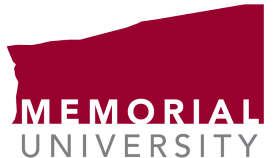

**Libraries**: json used to manage json files and convert them into dataframes to manage in Jupyter. BBytesIO helps decoding and finding special characters that could be inside player names. Such as "Rodríguez".

In [3]:
import pandas as pd
import numpy as np
import import_ipynb
import definitions as ds

importing Jupyter notebook from definitions.ipynb


**EVENTS**: Load "Events" json file focusing exclusively in England's games events. Filter to only get the needed id's to merge with useful information from other json files. 

In [5]:
#reading json file into dataframe.
Events_df=pd.read_json('events_England.json')

#flattening the json nested list into a dataframe. 
normalized_events=Events_df.explode('tags')
normalized_events=normalized_events.explode('positions')
normalized_events=pd.json_normalize(ds.json.loads(normalized_events.to_json(orient='records')))
normalized_events=normalized_events.drop('tags',axis=1)

#Creating start and finish position coordinates columns
DataStart=normalized_events.drop_duplicates(subset=['eventId','subEventName','playerId','matchId','eventName','teamId','matchPeriod','eventSec','subEventId','id','tags.id'],keep='first')
DataStart=DataStart.rename(columns={'positions.y':'start.y','positions.x':'start.x'})
DataFinish=normalized_events.drop_duplicates(subset=['eventId','subEventName','playerId','matchId','eventName','teamId','matchPeriod','eventSec','subEventId','id','tags.id'],keep='last')
DataFinish=DataFinish.rename(columns={'positions.y':'finish.y','positions.x':'finish.x'})

#merging both datasets to have start and finish positions united. Merge#1
Events_Dataset=pd.merge(DataStart,DataFinish,on=['eventId','subEventName','playerId','matchId','eventName','teamId','matchPeriod','eventSec','subEventId','id','tags.id'],how='left')

#joining tags labels with id of play
Tags=pd.read_csv('tags2name.csv')
Tags=Tags.drop('Label',axis=1)
Tags=Tags.rename(columns={'Tag':'tags.id'})


#merge#2 Creating central dataframe of information about events
Events_Dataset=pd.merge(Events_Dataset,Tags,on=['tags.id'],how='left')

**TEAMS**: Load "Teams" json file with city and Id information. This data will be merged into the main dataset of events.

In [6]:
#reading json file into dataframe.
teamInfoJson=ds.read_json_file('teams.json')
Teams_df=pd.read_json(teamInfoJson)

#selecting needed data from the match dataset
Teams_neededData=Teams_df[['officialName','wyId','city']]
Teams_neededData=Teams_neededData.rename(columns={'wyId':'teamId','city':'city_team'})


#merging with original dataset. Merge#4
Events_Dataset=pd.merge(Events_Dataset,Teams_neededData,on=['teamId'],how='left')

**MATCHES**: Load "Matches" json file describing gameweeks, date, winner, venue of play and id's with labels. Additionally connect them with home team stadiums to account for Home Teams and Away teams per match.

In [7]:
#reading json file into dataframe.
Match_England_df=pd.read_json('matches_England.json')

#selecting needed data from the match dataset
Match_neededData=Match_England_df[['gameweek','dateutc','winner','venue','wyId','label']]
Match_neededData=Match_neededData.rename(columns={'wyId':'matchId'})


#merging with original dataset. Merge#3
Events_Dataset=pd.merge(Events_Dataset,Match_neededData,on=['matchId'],how='left')

#merging stadium cities
Stadiums=pd.read_excel('Stadiums.xlsx')
Events_Dataset=pd.merge(Events_Dataset,Stadiums,on=['officialName'],how='left')

**PLAYERS**: Load "Players" json file describing basic information that may be useful. Connect to main dataset through player Id. 
<br>
For this set of data, since we may encounter special characters, we are going to use our function named `read_json_file` in order to decode the strings in the data. all we need as input is: 
>**filename**: Dataframe needed for conversion of data. 

*For more information, please visit this link:*

In [9]:
#reading Json file and converting it to dataframe
playerInfoJson=ds.read_json_file('players.json')
Players_df=pd.read_json(playerInfoJson)

#selecting needed data
Players_df=Players_df[['shortName','birthDate','height','passportArea','role','wyId','foot']]

#normalizing nested lists in dataframe.
roles=pd.json_normalize(Players_df['role'])
passport=pd.json_normalize(Players_df['passportArea'])

#joining in needed columns from nested lists. 
Players_df=Players_df.join(roles['name'])
passport=passport.rename(columns={'name':'Country'})
Players_df=Players_df.join(passport['Country'])
Players_df=Players_df.drop(['passportArea','role'],axis=1)


#merging data with central dataframe
Players_neededData=Players_df.rename(columns={'wyId':'playerId'})
Events_Dataset=pd.merge(Events_Dataset,Players_neededData,on=['playerId'],how='left')

**Initial dataset ready!**

In [10]:
Events_Dataset.head()

,eventId,subEventName,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,...,winner,venue,label,local_stadium,shortName,birthDate,height,foot,name,Country
0,8,Simple pass,25413,2499719,Pass,1609,1H,2.758649,85,177959171,...,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3",Emirates Stadium,A. Lacazette,1991-05-28,175.0,right,Forward,Guadeloupe
1,8,High pass,370224,2499719,Pass,1609,1H,4.946850,83,177959172,...,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3",Emirates Stadium,R. Holding,1995-09-20,189.0,right,Defender,England
2,8,Head pass,3319,2499719,Pass,1609,1H,6.542188,82,177959173,...,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3",Emirates Stadium,M. Özil,1988-10-15,180.0,left,Midfielder,Germany
3,8,Head pass,120339,2499719,Pass,1609,1H,8.143395,82,177959174,...,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3",Emirates Stadium,Mohamed Elneny,1992-07-11,180.0,right,Midfielder,Egypt
4,8,Simple pass,167145,2499719,Pass,1609,1H,10.302366,85,177959175,...,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3",Emirates Stadium,Bellerín,1995-03-19,178.0,right,Defender,Spain


**Save to excel.**

In [6]:
Events_Dataset.to_excel("Event EPL Dataset-1718.xlsx") 

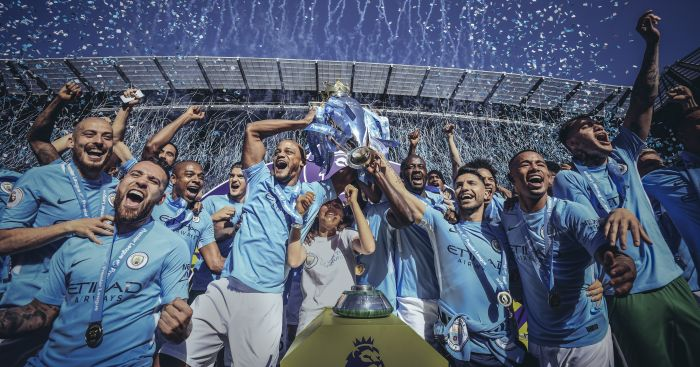

**Link to Original Dataset documentation**:
    https://figshare.com/collections/Soccer_match_event_dataset/4415000/5

**Published article from where Dataset was retrieved**:
Pappalardo, L., Cintia, P., Rossi, A., Massucco, E., Ferragina, P., Pedreschi, D., &amp; Giannotti, F. (2019). A public data  set of spatio-temporal match events in soccer competitions. Scientific Data, 6(1). https://doi.org/10.1038/s41597-019-0247-7 